# Dictionary-based Method
Investment Analysis with Machine Learning\
UROP 1100E (Man Yin Michael YEUNG, 2021 Fall)

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import jieba
import jieba.posseg as pseg
import paddle
import string
import re
from multiprocessing import Pool
from stopwordsiso import stopwords
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
from IPython.display import clear_output

### Retrieve Pre-processed Data

In [ ]:
merged_data = pd.read_parquet('D:/michael/full_version_data/preprocessed_data_2.parquet.gzip')
merged_data.shape

In [3]:
merged_data.head(3)

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content,jieba_sentence
0,181899,600323,2010-01-04,0.006658,-0.001522,-0.030300,"[南海发展nt, 水价n, 如期t, 上调v, 增厚v, 业绩n, 约d, 事项n, 公司n...","[[南海发展, 水价, 如期, 上调], [增厚, 业绩, 约], [事项], [公司, 今..."
1,181900,002024,2010-01-04,-0.004292,-0.022783,-0.047744,"[苏宁ns, 电器n, 内外s, 兼修v, 进入v, 新一轮nz, 增长期n, 投资vn, ...","[[苏宁, 电器, 内外, 兼修, 进入, 新一轮, 增长期], [投资, 要点], [行业..."
2,181901,002092,2010-01-04,0.030815,0.018962,0.055390,"[泰ns, 化学n, 发布v, 准东ns, 井田nr, 勘探vn, 报告n, 煤炭n, 开发...","[[中, 泰, 化学, 发布, 准东, 一, 井田, 勘探, 报告], [煤炭, 开发, 再..."


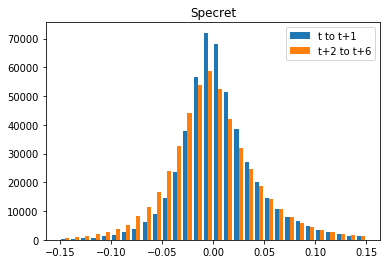

In [4]:
import matplotlib.pyplot as plt
x1 = merged_data['specret_2d']; x2 = merged_data['specret_tp2-tp6']
plt.hist([x1,x2], range=[-0.15,0.15],bins=30, label=['t to t+1', 't+2 to t+6'])
plt.title('Specret'); plt.legend(); plt.show()

### Read Sentiment Dictionaries

In [8]:
# ref: https://github.com/dictionaries2020/SentimentDictionaries
pos_words_1 = list(pd.read_csv('D:/michael/positive_sentiment_dict.csv')['word'])
neg_words_1 = list(pd.read_csv('D:/michael/negative_sentiment_dict.csv')['word'])
len(pos_words_1), len(neg_words_1)

(3592, 1633)

In [9]:
# ref: https://github.com/dictionaries2020/SentimentDictionaries
pos_words_2 = list(pd.read_csv('D:/michael/positive_sentiment_dict_2.csv')['word'])
neg_words_2 = list(pd.read_csv('D:/michael/negative_sentiment_dict_2.csv')['word'])
len(pos_words_2), len(neg_words_2)

(912, 965)

In [10]:
# ref: https://github.com/MengLingchao/Chinese_financial_sentiment_dictionary
pos_words_3 = list(pd.read_csv('D:/michael/positive_sentiment_dict_3.csv')['word'])
neg_words_3 = list(pd.read_csv('D:/michael/negative_sentiment_dict_3.csv')['word'])
pos_words_3 = [word[:-1] for word in pos_words_3]; neg_words_3 = [word[:-1] for word in neg_words_3]
len(pos_words_3), len(neg_words_3)

(3338, 5890)

### Calculate Sentiment

In [12]:
def get_sentiment(list_in, pos_words_adopted, neg_words_adopted, variant):
    pos = 0; neg = 0; count = 0
    if variant: list_in = list(set(list_in))
    for word in list_in:
        word = str(re.findall(r'[\u4e00-\u9fff]+', word))[2:-2]; count += 1
        if word in pos_words_adopted: pos += 1
        if word in neg_words_adopted: neg += 1
    return [pos, neg, count]

In [27]:
def get_sentiment_sentence(list_in, pos_words_adopted, neg_words_adopted, variant):
    pos = 0; neg = 0; count = 0
    for sentence in list_in:
        count += 1
        if variant: sentence = list(set(list(sentence)))
        pos_word = 0; neg_word = 0
        for word in sentence:
            word = str(re.findall(r'[\u4e00-\u9fff]+', word))[2:-2]
            if word in pos_words_adopted: pos_word += 1
            if word in neg_words_adopted: neg_word += 1
        if pos_word - neg_word > 0: pos += 1
        elif pos_word - neg_word < 0: neg += 1
    return [pos, neg, count]

### Compute Benchmark Correlations

In [28]:
def get_charged_counts(df_in, dicts):
    for dict_num in dicts:
        print('Loading Dict {DictNum}\t{Now}'.format(DictNum=dict_num,Now=dt.datetime.now()))
        pos_dict = eval('pos_words_{DictNum}'.format(DictNum=dict_num))
        neg_dict = eval('neg_words_{DictNum}'.format(DictNum=dict_num))
        df_in['dict{DictNum}_words'.format(DictNum=dict_num)]\
        = df_in['jieba_content'].map(lambda x: get_sentiment(x,pos_dict,neg_dict,False))
        print('... Sentence Version\t{Now}'.format(DictNum=dict_num,Now=dt.datetime.now()))
        df_in['dict{DictNum}_sentences'.format(DictNum=dict_num)]\
        = df_in['jieba_sentence'].map(lambda x: get_sentiment_sentence(x,pos_dict,neg_dict,False))
    print('End Time \t{Now}'.format(Now=dt.datetime.now()))
    return df_in

In [ ]:
merged_data = get_charged_counts(merged_data.copy(),[1,2,3])

In [32]:
merged_data.head(3)

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content,jieba_sentence,dict1_words,dict1_sentences,dict2_words,dict2_sentences,dict3_words,dict3_sentences
0,181899,600323,2010-01-04,0.006658,-0.001522,-0.030300,"[南海发展nt, 水价n, 如期t, 上调v, 增厚v, 业绩n, 约d, 事项n, 公司n...","[[南海发展, 水价, 如期, 上调], [增厚, 业绩, 约], [事项], [公司, 今...","[31, 5, 198]","[18, 2, 39]","[11, 4, 198]","[8, 2, 39]","[8, 4, 198]","[6, 2, 39]"
1,181900,002024,2010-01-04,-0.004292,-0.022783,-0.047744,"[苏宁ns, 电器n, 内外s, 兼修v, 进入v, 新一轮nz, 增长期n, 投资vn, ...","[[苏宁, 电器, 内外, 兼修, 进入, 新一轮, 增长期], [投资, 要点], [行业...","[69, 6, 330]","[26, 2, 47]","[48, 5, 330]","[21, 3, 47]","[57, 7, 330]","[24, 4, 47]"
2,181901,002092,2010-01-04,0.030815,0.018962,0.055390,"[泰ns, 化学n, 发布v, 准东ns, 井田nr, 勘探vn, 报告n, 煤炭n, 开发...","[[中, 泰, 化学, 发布, 准东, 一, 井田, 勘探, 报告], [煤炭, 开发, 再...","[23, 0, 185]","[16, 0, 29]","[8, 0, 185]","[7, 0, 29]","[16, 0, 185]","[11, 0, 29]"


In [45]:
merged_data.jieba_content = merged_data.jieba_content.map(list)
merged_data.jieba_sentence = merged_data.jieba_sentence.map(list)

In [51]:
merged_data.to_parquet('D:/michael/full_version_data/data_dict_charged.parquet.gzip')

In [68]:
def get_dict_scores(df_in,dict_num):
    df_in['dict{Dn}_score1'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_words.map(lambda x: x[0]/x[2] if x[2]!=0 else np.nan)'.format(Dn=dict_num))
    df_in['dict{Dn}_score2'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_words.map(lambda x: -x[1]/x[2] if x[2]!=0 else np.nan)'.format(Dn=dict_num))
    df_in['dict{Dn}_score3'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_words.map(lambda x: (x[0]-x[1])/x[2] if x[2]!=0 else np.nan)'.format(Dn=dict_num))
    df_in['dict{Dn}_score4'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_words.map(lambda x: x[0]/(x[0]+x[1]) if x[0]+x[1]!=0 else np.nan)'.format(Dn=dict_num))
    df_in['dict{Dn}_score5'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_words.map(lambda x: -x[1]/(x[0]+x[1]) if x[0]+x[1]!=0 else np.nan)'.format(Dn=dict_num))
    df_in['dict{Dn}_score6'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_words.map(lambda x: (x[0]-x[1])/(x[0]+x[1]) if x[0]+x[1]!=0 else np.nan)'.format(Dn=dict_num))
    df_in['dict{Dn}_score7'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_sentences.map(lambda x: x[0]/x[2] if x[2]!=0 else np.nan)'.format(Dn=dict_num))
    df_in['dict{Dn}_score8'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_sentences.map(lambda x: -x[1]/x[2] if x[2]!=0 else np.nan)'.format(Dn=dict_num))
    df_in['dict{Dn}_score9'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_sentences.map(lambda x: (x[0]-x[1])/x[2] if x[2]!=0 else np.nan)'.format(Dn=dict_num))
    df_in['dict{Dn}_score10'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_sentences.map(lambda x: x[0]/(x[0]+x[1]) if x[0]+x[1]!=0 else np.nan)'.format(Dn=dict_num))
    df_in['dict{Dn}_score11'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_sentences.map(lambda x: -x[1]/(x[0]+x[1]) if x[0]+x[1]!=0 else np.nan)'.format(Dn=dict_num))
    df_in['dict{Dn}_score12'.format(Dn=dict_num)] = eval('df_in.dict{Dn}_sentences.map(lambda x: (x[0]-x[1])/(x[0]+x[1]) if x[0]+x[1]!=0 else np.nan)'.format(Dn=dict_num))
    return df_in

In [76]:
for dict_num in [1,2,3]:
    merged_data = get_dict_scores(merged_data.copy(),dict_num)

In [4]:
def get_corr(df_in,dict_num=1,score_num=12,ret_col='specret_2d',method='spearman'):
    return df_in[['dict{Dn}_score{Sn}'.format(Dn=dict_num,Sn=score_num),ret_col]].corr(method=method).iloc[0][ret_col]

In [109]:
get_corr(merged_data,dict_num=1,score_num=12,ret_col='specret_2d',method='spearman')

0.10605224968325222

In [111]:
merged_data.shape

(497665, 50)

In [112]:
merged_data.head(3)

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content,jieba_sentence,dict1_words,dict1_sentences,...,dict3_score3,dict3_score4,dict3_score5,dict3_score6,dict3_score7,dict3_score8,dict3_score9,dict3_score10,dict3_score11,dict3_score12
0,181899,600323,2010-01-04,0.006658,-0.001522,-0.030300,"[南海发展nt, 水价n, 如期t, 上调v, 增厚v, 业绩n, 约d, 事项n, 公司n...","[[南海发展, 水价, 如期, 上调], [增厚, 业绩, 约], [事项], [公司, 今...","[31, 5, 198]","[18, 2, 39]",...,0.020202,0.666667,-0.333333,0.333333,0.153846,-0.051282,0.102564,0.750000,-0.250000,0.500000
1,181900,002024,2010-01-04,-0.004292,-0.022783,-0.047744,"[苏宁ns, 电器n, 内外s, 兼修v, 进入v, 新一轮nz, 增长期n, 投资vn, ...","[[苏宁, 电器, 内外, 兼修, 进入, 新一轮, 增长期], [投资, 要点], [行业...","[69, 6, 330]","[26, 2, 47]",...,0.151515,0.890625,-0.109375,0.781250,0.510638,-0.085106,0.425532,0.857143,-0.142857,0.714286
2,181901,002092,2010-01-04,0.030815,0.018962,0.055390,"[泰ns, 化学n, 发布v, 准东ns, 井田nr, 勘探vn, 报告n, 煤炭n, 开发...","[[中, 泰, 化学, 发布, 准东, 一, 井田, 勘探, 报告], [煤炭, 开发, 再...","[23, 0, 185]","[16, 0, 29]",...,0.086486,1.000000,0.000000,1.000000,0.379310,0.000000,0.379310,1.000000,0.000000,1.000000


In [110]:
merged_data.to_parquet('D:/michael/full_version_data/data_dict_scores.parquet.gzip')

In [5]:
score_df_cols = []
for i in range(1,13):
    score_df_cols.append('score_'+str(i))

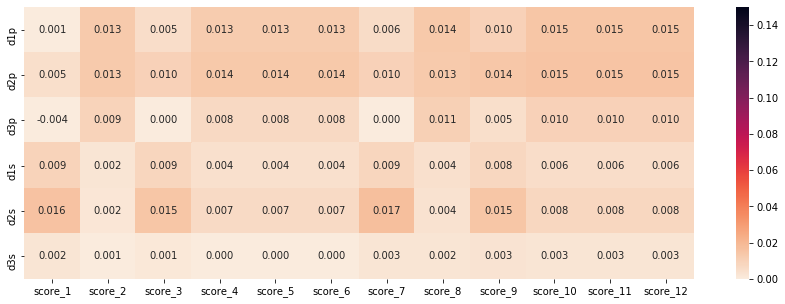

In [8]:
#used_data = merged_data
used_data = merged_data.loc[merged_data.date >= dt.datetime(2015,1,1)]

import seaborn as sns
import matplotlib.pyplot as plt
score_df = pd.DataFrame(columns=score_df_cols)
for dict_num in [1,2,3]:
    scores = []
    for score_num in range(1,13):
        scores.append(round(get_corr(used_data,dict_num=dict_num,score_num=score_num,ret_col='specret_tp2-tp6',method='pearson'),5))
    row = pd.DataFrame([scores],columns=score_df_cols, index=['d'+str(dict_num)+'p'])
    score_df = score_df.append(row)
for dict_num in [1,2,3]:
    scores = []
    for score_num in range(1,13):
        scores.append(round(get_corr(used_data,dict_num=dict_num,score_num=score_num,ret_col='specret_tp2-tp6',method='spearman'),5))
    row = pd.DataFrame([scores],columns=score_df_cols, index=['d'+str(dict_num)+'s'])
    score_df = score_df.append(row)
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(score_df, annot=True, cmap='rocket_r', ax=ax, fmt='.3f', vmin=0, vmax=0.15)
plt.savefig('D:/michael/full_version_data/img/test_data_dict_corr_heatmap_tp2-tp6.png')
plt.show()

In [2]:
merged_data = pd.read_parquet('D:/michael/full_version_data/data_dict_scores.parquet.gzip')

In [3]:
merged_data = merged_data.sort_values(by='date', ascending=True)

In [11]:
merged_data.tail()

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,jieba_content,jieba_sentence,dict1_words,dict1_sentences,...,dict3_score3,dict3_score4,dict3_score5,dict3_score6,dict3_score7,dict3_score8,dict3_score9,dict3_score10,dict3_score11,dict3_score12
497061,1373471,600588,2021-08-19,-0.028538,-0.022273,-0.020009,"[用友n, 网络n, 坚定a, 落实a, 战略n, 云ns, 服务vn, 业务收入n, 占v...","[[用友, 网络, 坚定, 落实, II, 战略], [云, 服务, 业务收入, 占, 比,...","[102, 10, 629]","[70, 6, 106]",...,0.112878,0.865979,-0.134021,0.731959,0.584906,-0.056604,0.528302,0.911765,-0.088235,0.823529
497162,1373185,002391,2021-08-19,-0.005783,-0.003988,-0.041742,"[长青nr, 股份n, 上半年t, 稳中有b, 增v, 期待v, 新a, 项目n, 有序n,...","[[长青, 股份, 上半年, 稳中有, 增], [期待, 新, 项目, 有序, 推进], [...","[49, 10, 316]","[32, 7, 62]",...,0.082278,0.809524,-0.190476,0.619048,0.419355,-0.080645,0.338710,0.838710,-0.161290,0.677419
497163,1373186,300498,2021-08-19,0.001919,0.002674,0.023425,"[温氏nr, 股份n, 肉猪n, 养殖vn, 业务n, 承压v, 肉鸡n, 养殖vn, 业务...","[[温氏, 股份, 肉猪, 养殖, 业务, 承压], [肉鸡, 养殖, 业务, 扭亏为盈],...","[30, 24, 368]","[20, 14, 66]",...,0.008152,0.529412,-0.470588,0.058824,0.257576,-0.212121,0.045455,0.548387,-0.451613,0.096774
497152,1373353,603816,2021-08-19,0.051282,0.041702,-0.009453,"[顾家n, 家居n, 业绩n, 超v, 预期vn, 产品n, 渠道n, 共振n, 向上d, ...","[[顾家, 家居, 业绩, 超, 预期], [产品, 渠道, 共振, 向上], [ , ,...","[52, 7, 342]","[35, 4, 68]",...,0.087719,0.826087,-0.173913,0.652174,0.411765,-0.044118,0.367647,0.903226,-0.096774,0.806452
497286,1373390,300015,2021-08-19,-0.015191,-0.055872,0.012988,"[爱尔nr, 眼科n, 收购v, 体外s, 培育vn, 医院n, 持续vd, 完善v, 网络...","[[爱尔, 眼科, 收购, 体外, 培育, 医院], [持续, 完善, 网络, 布局], [...","[37, 1, 256]","[26, 0, 46]",...,0.113281,0.914286,-0.085714,0.828571,0.478261,-0.043478,0.434783,0.916667,-0.083333,0.833333
